# ML Capstone 1 - Part 3 E-Commerce Customer Segmentation

## TODO
 
### Clustering Algorithms for Customer Segmentation
- Applying unsupervised learning algorithms (e.g., K-means clustering, Hierarchical clustering) to segment customers
- Determining the optimal number of clusters using techniques such as the elbow method or silhouette score
- Interpreting customer segments based on cluster characteristics and feature importance
- Visualize the clusters using PCA

### Classification for Segment Prediction (8 pts)
- Using any of the supervised learning classification algorithms (e.g., Random Forest, Gradient Boosting, Logistic Regression) predict customer segments:

    - Split the dataset into training, validation and test sets
    - Training classification models to predict the segment to which a customer belongs
    - Validating the classification model's performance and generalization using cross-validation techniques
    - Evaluating model performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score)
    - Iteratively refining segmentation and classification strategies based on validation results and stakeholder feedback


### Grading and Important Instructions
- Each of the above steps are mandatory and should be completed in good faith
- Make sure before submitting that the code is in fully working condition
- It is fine to make use of ChatGPT, stackoverflow type resources, just provide the reference links from where you got it
- Debugging is an art, if you find yourself stuck with errors, take help of stackoverflow and ChatGPT to resolve the issue and if it's still unresolved, reach out to me for help.
- You need to score atleast 7/10 to pass the project, anything less than that will be marked required, needing resubmission.
- Feedback will be provided on 3 levels (Awesome, Suggestion, & Required). Required changes are mandatory to be made.
- For submission, please upload the project on github and share the link to the file with us through LMS.

#### Write your code below and do not delete the above instructions

Importing all the necessary libraries

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Import necessary libraries for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

Loading the pre-processed dataset and making the model ready for applying K-means clustering.

In [3]:
data = pd.read_csv("ecommerce_data_cleaned.csv")
#encoding='ISO-8859-1'

if 'TotalAmount' not in data.columns:
    data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

# Selecting numerical and categorical features
numerical_features = ['Quantity', 'UnitPrice', 'TotalAmount']
categorical_features = ['Country'] if 'Country' in data.columns else []

if categorical_features:
    encoder = OneHotEncoder(sparse=False, drop='first')  
    encoded_features = encoder.fit_transform(data[categorical_features])
    encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
    data = pd.concat([data.reset_index(drop=True), encoded_df], axis=1)

# Dropping original categorical columns
data = data.drop(columns=categorical_features)

Preparing the model by dropping columns, standardization and scaling features

In [4]:
scaler_minmax = MinMaxScaler()
data_normalized = scaler_minmax.fit_transform(data[numerical_features])

# Standardization for Classification
scaler_standard = StandardScaler()
data_standardized = scaler_standard.fit_transform(data[numerical_features])

# Adding scaled features to the dataset
data_normalized_df = pd.DataFrame(data_normalized, columns=[f"{col}_normalized" for col in numerical_features])
data_standardized_df = pd.DataFrame(data_standardized, columns=[f"{col}_standardized" for col in numerical_features])
data = pd.concat([data, data_normalized_df, data_standardized_df], axis=1)

Dimensionality Reduction (PCA for Clustering). Reducing to 2 dimensions for visualization or clustering


In [5]:
pca = PCA(n_components=2)  
 
data_pca = pca.fit_transform(data_normalized)

# Adding PCA results to the dataset
data['PCA_1'] = data_pca[:, 0]
data['PCA_2'] = data_pca[:, 1]


if 'Cluster' not in data.columns:
    data['Cluster'] = np.random.randint(0, 4, size=len(data))  # Simulate clusters

Data Splitting (For Classification)
Assuming 'Cluster' column exists or generating a synthetic target for demonstration

In [6]:
X = data.drop(columns=['Cluster'])  # Features
y = data['Cluster']  # Target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)



Subsample the data if necessary to speed up silhouette score calculations. Determine Optimal Number of Clusters using Elbow Method and Silhouette Score

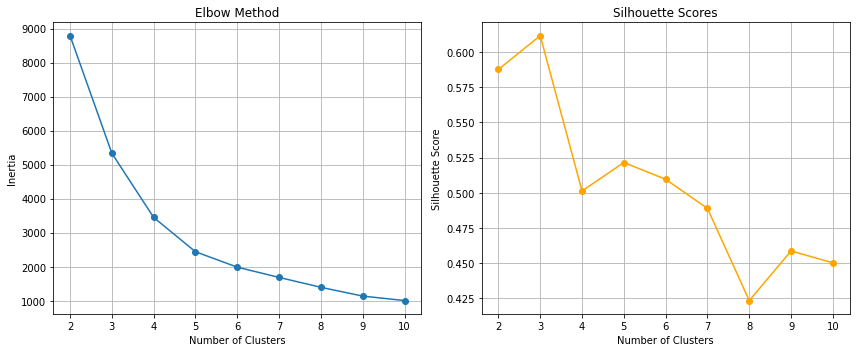

In [7]:

data_sampled = data[['PCA_1', 'PCA_2']].sample(n=5000, random_state=42) if len(data) > 5000 else data[['PCA_1', 'PCA_2']]


inertia = []
silhouette_scores = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data[['PCA_1', 'PCA_2']])
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score on the subsampled data
    labels = kmeans.predict(data_sampled)
    silhouette_scores.append(silhouette_score(data_sampled, labels))

# Plotting Elbow Method
plt.figure(figsize=(12, 5))

# Elbow Method Plot
plt.subplot(1, 2, 1)
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)

# Silhouette Scores Plot
plt.subplot(1, 2, 2)
plt.plot(range_clusters, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


Apply Clustering Algorithm (K-means as an example)

In [8]:
optimal_clusters = 4  # Replace this based on the Elbow/Silhouette analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(data[['PCA_1', 'PCA_2']])

# Cluster Characteristics
cluster_summary = data.groupby('Cluster').agg({
    'Quantity': ['mean', 'sum'],
    'UnitPrice': ['mean', 'sum'],
    'TotalAmount': ['mean', 'sum']
}).rename(columns={'TotalAmount': 'TotalSales'})

# Renaming columns for better readability
cluster_summary.columns = ['AvgQuantity', 'TotalQuantity', 'AvgUnitPrice', 'TotalUnitPrice', 'AvgTotalAmount', 'TotalSales']
cluster_summary.reset_index(inplace=True)

# Display the cluster summary using pandas or print
print("Cluster Summary:")
print(cluster_summary)

cluster_summary.to_csv("cluster_summary.csv", index=False)
print("Cluster summary saved to 'cluster_summary.csv'.")

Cluster Summary:
   Cluster  AvgQuantity  TotalQuantity  AvgUnitPrice  TotalUnitPrice  \
0        0     9.597151        2256962      1.316285      309550.654   
1        1     3.287673         112445      9.027021      308742.170   
2        2    65.017132         975322      1.405954       21090.710   
3        3     4.387692         434579      3.994403      395625.690   

   AvgTotalAmount   TotalSales  
0       11.424620  2686727.964  
1       28.938300   989747.740  
2       91.298313  1369565.990  
3       17.250333  1708559.240  
Cluster summary saved to 'cluster_summary.csv'.


Displaying and Saving the summary to a CSV file for external use

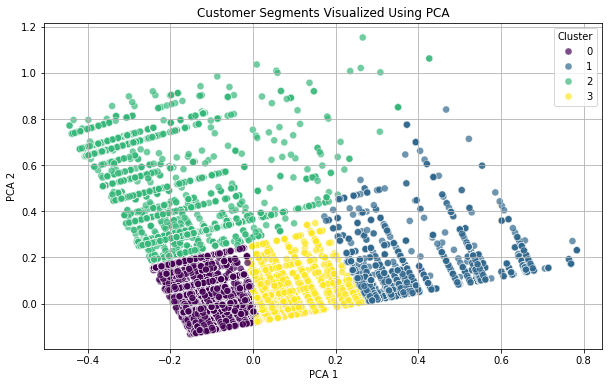

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA_1', y='PCA_2', hue='Cluster', data=data,
    palette='viridis', s=50, alpha=0.7
)
plt.title('Customer Segments Visualized Using PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



Visualizing Clusters using PCA with PCA 1 vs PCA 2 as a customer segmentation

In [12]:
# Identify non-numeric columns in the dataset
non_numeric_columns = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)




Non-numeric columns: Index(['StockCode', 'Description', 'InvoiceDate'], dtype='object')


In [13]:
# Step 2: Encode non-numeric columns using one-hot encoding
if not non_numeric_columns.empty:
    X = pd.get_dummies(X, columns=non_numeric_columns, drop_first=True)


Using One-hot encoding for dropping non-numeric columns. Now, splitting the dataset for training, validating and testing the dataset for classification

In [14]:
# Split the Dataset into Training, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
# Train a Classification Model (Random Forest as an example)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

Training the random forest classification model and validating it

In [ ]:
# Validate the Model's Performance
y_val_pred = rf_model.predict(X_val)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [ ]:
# Cross-Validation for Generalization
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Scores:", cv_scores)
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")

# Evaluate on the Test Set
y_test_pred = rf_model.predict(X_test)

# Generate classification report
print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred))

# Refinement Strategy (Optional)
# Iterate and refine the model by tuning hyperparameters, trying different models, or improving features

# Save the model and results
import joblib
joblib.dump(rf_model, "customer_segmentation_model.pkl")
print("\nModel saved as 'customer_segmentation_model.pkl'")

Generating the cross-validation and classification report and saving the model.